<a href="https://colab.research.google.com/github/jeffblackadar/image_work/blob/master/Categorized_E_II_and_G_VI_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# From: https://github.com/spmallick/learnopencv/blob/master/KerasCNN-CIFAR/keras-cnn-cifar10.ipynb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, InputLayer
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
# Thanks to
# https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
def getListOfFiles(dirName):
    import os
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            #allFiles = allFiles + getListOfFiles(fullPath)
            print(fullPath)
        else:
            allFiles.append(entry)
            #print(entry)    
    return allFiles 


# Copy images into train, validation and test directories
This only needs to be run once.
20 Images training
10 validation

In [0]:
#Move images
def copy_images(original_dataset_dir, portrait_image_prefix, train_portrait_dir, validation_portrait_dir, test_portrait_dir):
    #run it once time for each class of images
    import os, shutil

    list_of_files = getListOfFiles(original_dataset_dir)
    print(len(list_of_files))
    # adjust the ranges based on how the images should be split.
    # an equal number per class is required.
    #train
    for i in range(0,37):
        src = os.path.join(original_dataset_dir, list_of_files[i])
        if os.path.exists(src):
            dst = os.path.join(train_portrait_dir, list_of_files[i])
            shutil.copyfile(src, dst)

    #validation
    for i in range(37,55):
        src = os.path.join(original_dataset_dir, list_of_files[i])
        if os.path.exists(src):
            dst = os.path.join(validation_portrait_dir, list_of_files[i])
            shutil.copyfile(src, dst)

    #test
    for i in range(55,73):
        src = os.path.join(original_dataset_dir, list_of_files[i])
        if os.path.exists(src):
            dst = os.path.join(test_portrait_dir, list_of_files[i])
            shutil.copyfile(src, dst)


In [0]:
import os
base_dir = '/content/drive/My Drive/coin-image-processor/portraits'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

#make each directory for the types of images
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

portrait = 'all'

#make each sub-directory
train_portrait_dir = os.path.join(train_dir, portrait)
if not os.path.exists(train_portrait_dir):
    os.mkdir(train_portrait_dir)

validation_portrait_dir = os.path.join(validation_dir, portrait)
if not os.path.exists(validation_portrait_dir):
    os.mkdir(validation_portrait_dir)

test_portrait_dir = os.path.join(test_dir, portrait)
if not os.path.exists(test_portrait_dir):
    os.mkdir(test_portrait_dir)
    
    
copy_images('/content/drive/My Drive/coin-image-processor/photos/elizabeth_young', 'eII', train_portrait_dir, validation_portrait_dir, test_portrait_dir)
copy_images('/content/drive/My Drive/coin-image-processor/photos/george_vi', 'gvi', train_portrait_dir, validation_portrait_dir, test_portrait_dir)

print(train_portrait_dir)
print('total training portrait images:', len(os.listdir(train_portrait_dir)))
print(validation_portrait_dir)
print('total validation portrait images:', len(os.listdir(validation_portrait_dir)))
print(test_portrait_dir)
print('total test portrait images:', len(os.listdir(test_portrait_dir)))


/content/drive/My Drive/coin-image-processor/photos/elizabeth_young/.ipynb_checkpoints
75
85
/content/drive/My Drive/coin-image-processor/portraits/train/all
total training portrait images: 74
/content/drive/My Drive/coin-image-processor/portraits/validation/all
total validation portrait images: 36
/content/drive/My Drive/coin-image-processor/portraits/test/all
total test portrait images: 36


Set up Training, Testing, Validation images.
one_hot_label them:
1,0 = Elizabeth II
0,1 = George VI


In [0]:
#https://blog.francium.tech/build-your-own-image-classifier-with-tensorflow-and-keras-dc147a15e38e
  
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

training_dir = "/content/drive/My Drive/coin-image-processor/portraits/train/all"
test_dir = "/content/drive/My Drive/coin-image-processor/portraits/test/all"
validation_dir = "/content/drive/My Drive/coin-image-processor/portraits/validation/all"

#train_data = '/TensorFlow/ImageData/Vehicles/train'
#test_data = '/TensorFlow/ImageData/Vehicles/test'
train_data = training_dir 
test_data = test_dir
validation_data = validation_dir

def one_hot_label(img):
    label = img.split('.')[0]
    label = label[:3]
    if label == 'eII':
        ohl = np.array([1,0])
    elif label == 'gvi':
        ohl = np.array([0,1])

    return ohl

def train_data_with_label():
    train_images = []
    print("*** Train ***")
    for i in tqdm(os.listdir(train_data)):
        path = os.path.join(train_data, i)
        print(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        #plt.imshow(img)
        print(path)
        print(one_hot_label(i))
        train_images.append([np.array(img), one_hot_label(i)])
        shuffle(train_images)
    return train_images

def test_data_with_label():
    print("*** Test ***")
    test_images = []
    for i in tqdm(os.listdir(test_data)):
        path = os.path.join(test_data, i)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)        
        img = cv2.resize(img, (128, 128))
        #plt.imshow(img)
        print(path)
        print(one_hot_label(i))
        test_images.append([np.array(img), one_hot_label(i)])
        #shuffle(test_images)
    return test_images

def validation_data_with_label():
    print("*** Validation ***")
    validation_images = []
    for i in tqdm(os.listdir(validation_data)):
        path = os.path.join(validation_data, i)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)        
        img = cv2.resize(img, (128, 128))
        #plt.imshow(img)
        print(path)
        print(one_hot_label(i))
        validation_images.append([np.array(img), one_hot_label(i)])
        #shuffle(validation_images)
    return validation_images
  
  
  
training_images = train_data_with_label()
testing_images = test_data_with_label()
validation_images = validation_data_with_label()
tr_img_data = np.array([i[0] for i in training_images]).reshape(-1,128,128,1)
tr_lbl_data = np.array([i[1] for i in training_images])
tst_img_data = np.array([i[0] for i in testing_images]).reshape(-1,128,128,1)
tst_lbl_data = np.array([i[1] for i in testing_images])
val_img_data = np.array([i[0] for i in validation_images]).reshape(-1,128,128,1)
val_lbl_data = np.array([i[1] for i in validation_images])

 12%|█▏        | 9/74 [00:00<00:00, 80.71it/s]

*** Train ***
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2900.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2900.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2901.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2901.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2903.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2903.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2906.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2906.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2907.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2907.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2910.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2910.png
[1 0]
/content/drive/My Drive/co

 34%|███▍      | 25/74 [00:00<00:00, 78.64it/s]

/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2930.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2931.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2931.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2933.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2933.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2934.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2934.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2936.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2936.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2937.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2937.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2940.png
/content/drive/My Drive/coin-image-proce

 55%|█████▌    | 41/74 [00:00<00:00, 77.67it/s]

/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2955.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2956.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2956.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2957.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2957.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2958.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII2958.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII3000.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII3000.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII3002.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/eII3002.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3370.png
/content/drive/My Drive/coin-image-proce

 77%|███████▋  | 57/74 [00:00<00:00, 75.67it/s]

/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3420.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3421.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3421.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3430.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3430.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3431.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3431.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3440.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3440.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3441.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3441.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3450.png
/content/drive/My Drive/coin-image-proce

  0%|          | 0/36 [00:00<?, ?it/s]

/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3510.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3511.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3511.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3520.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3520.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3521.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3521.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3530.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3530.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3531.png
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3531.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/train/all/gvi3331.png
/content/drive/My Drive/coin-image-proce

 44%|████▍     | 16/36 [00:00<00:00, 78.73it/s]

/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3172.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3180.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3181.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3190.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3191.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3200.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3201.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3210.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3211.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3220.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3221.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/test/all/eII3230.png
[1 0]
/content/drive/M

 89%|████████▉ | 32/36 [00:00<00:00, 77.16it/s]

/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3931.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3940.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3941.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3950.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3951.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3960.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3961.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3970.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3971.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3980.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3981.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi3990.png
[0 1]
/content/drive/M

 22%|██▏       | 8/36 [00:00<00:00, 79.84it/s]

/content/drive/My Drive/coin-image-processor/portraits/test/all/gvi4011.png
[0 1]
*** Validation ***
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3010.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3012.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3020.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3022.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3090.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3092.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3100.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3102.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3110.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3112.png
[1 0]
/content/drive/My D

 67%|██████▋   | 24/36 [00:00<00:00, 75.18it/s]

/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3140.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3142.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3150.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/eII3152.png
[1 0]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3360.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3361.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3800.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3801.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3810.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3820.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3811.png
[0 1]
/content/drive/My Drive/coin-ima

100%|██████████| 36/36 [00:00<00:00, 73.37it/s]

/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3871.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3880.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3881.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3910.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3911.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3920.png
[0 1]
/content/drive/My Drive/coin-image-processor/portraits/validation/all/gvi3921.png
[0 1]


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
#         zoom_range=0.2, # randomly zoom into images
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        #width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip=True,  # randomly flip images
        #vertical_flip=False)  # randomly flip images


    rescale=1./255,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode = "nearest",    
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=20,
    horizontal_flip=False)

In [0]:
def createModel3():
    model = Sequential()
    
    model.add(InputLayer(input_shape=(128,128,1)))
    model.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=5, padding='same'))
    
    model.add(Conv2D(filters=50,kernel_size=5,strides=1,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=5, padding='same'))
    
    model.add(Conv2D(filters=80,kernel_size=5,strides=1,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=5, padding='same'))

    model.add(Conv2D(filters=130,kernel_size=5,strides=1,padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=5, padding='same'))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    #number of classes
    # 1,0 E-II
    # 0,1 G-VI
    model.add(Dense(2, activation='softmax'))

    return model
  

model2 = createModel3()
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

batch_size = 51
epochs = 10

# datagen.fit(train_data)
#it doesn't make sense we mix test and validation

# Fit the model on the batches generated by datagen.flow().
history2 = model2.fit_generator(datagen.flow(tr_img_data , tr_lbl_data, batch_size=batch_size),
                              #steps_per_epoch=int(np.ceil(tr_img_data .shape[0] / float(batch_size))),
                              steps_per_epoch=74,
                              epochs=epochs,
                              validation_data=(val_img_data, val_lbl_data),
                              #validation_split=0.3,
                              validation_steps=17,
                              shuffle=True,
                              workers=4)

model2.evaluate(tst_img_data, tst_lbl_data)


#fit(self, x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, 
#validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, 
#initial_epoch=0, steps_per_epoch=None, validation_steps=None)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 128, 128, 32)      832       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 26, 26, 50)        40050     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 6, 6, 50)          0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 6, 6, 80)          100080    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 2, 2, 80)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 2, 2, 130)       

[3.5817989773220487, 0.7777777777777778]

Text(0.5, 1.0, 'Loss Curves')

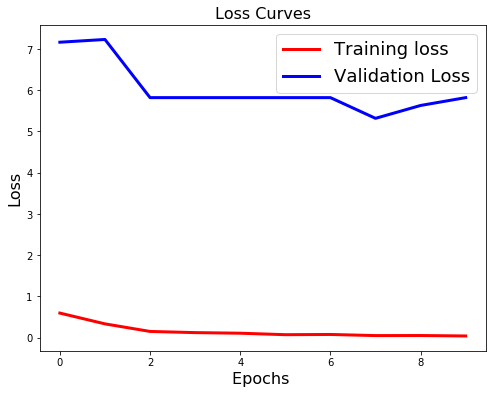

In [0]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

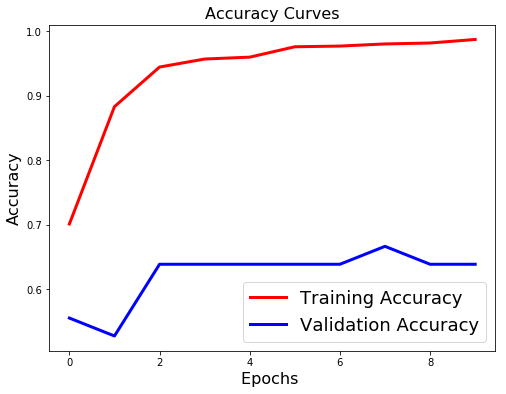

In [0]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['acc'],'r',linewidth=3.0)
plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

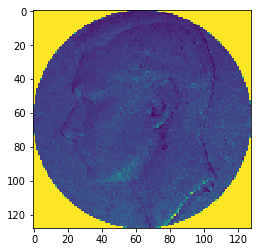

[[0. 1.]]


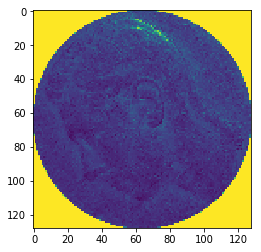

[[0. 1.]]


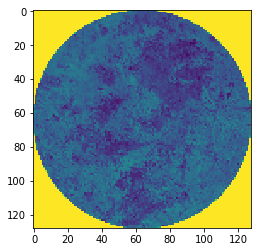

[[1. 0.]]


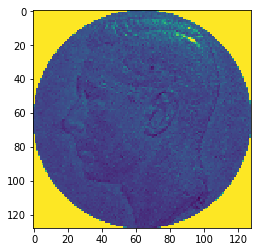

[[0. 1.]]


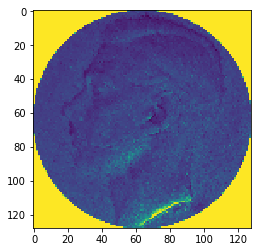

[[0. 1.]]


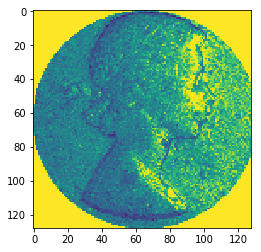

[[1. 0.]]


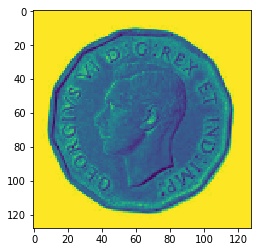

[[1. 0.]]


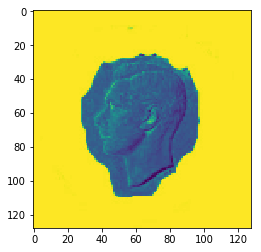

[[1. 0.]]


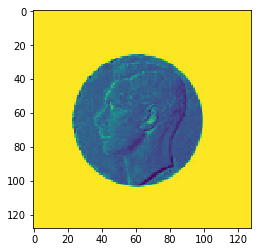

[[1. 0.]]


In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np

#from keras.models import load_model
#model_final = load_model('/content/portrait_model.h5')

#function that reads image, shows it on screen and makes a prediction


def predict_for(img_name):
    #load image from file - VGG16 takes (244,244) input
    #myimg = load_img(img_name, target_size=(300,300))
    myimg = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)        
    myimg = cv2.resize(myimg, (128, 128))
    plt.imshow(myimg)
    plt.show()

    #convert image pixels to array
    myimg = img_to_array(myimg)
    myimg = np.expand_dims(myimg, axis=0)
    # prepare image for the VGG model
    #myimg = preprocess_input(myimg)
    #predict probability for all 1000 classes
    pred=int(model2.predict(myimg)[0][0])
    print(model2.predict(myimg))
    #print('Prediction for %s: %s'%(img_name, class_names[pred]))

predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/george_vi/gvi3490.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/george_vi/gvi3491.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/george_vi/gvi3500.png')
predict_for('/content/drive/My Drive/coin-image-processor/portraits/test/george_vi/gvi3511.png')
predict_for('/content/drive/My Drive/coin-image-processor/photos/george_vi/gvi3330.png')
predict_for('/content/drive/My Drive/coin-image-processor/photos/elizabeth_young/eII2903.png')
predict_for('/content/drive/My Drive/coin-image-processor/gvi_test_full.jfif')
predict_for('/content/drive/My Drive/coin-image-processor/gvi_test_roughcrop.jpg')
predict_for('/content/drive/My Drive/coin-image-processor/gvi_test_roundcrop.jpg')
